<a href="https://colab.research.google.com/github/Jonuxs/AdvancedDataScienceCapstone/blob/main/ModelTrainingTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Description

In this notebook we will train and test RFC and NN models and comprate how they perform wiht different features.

## Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Imports

In [ ]:
import os
import glob
import time
import numpy as np
import tensorflow as tf
import random as random
import re
import datetime
import scipy

import math
import pandas as pd
from pandas import read_excel
from pandas.tseries.offsets import *
import sklearn
from sklearn.model_selection import cross_validate, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from keras.layers import LeakyReLU

from keras.regularizers import l1
from keras.regularizers import l2

from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv1D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Add
from tensorflow.keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from tensorflow.keras.models import Sequential, load_model, model_from_config
import tensorflow.keras.backend as K
import datetime 
from datetime import datetime
from datetime import date
from datetime import timedelta
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from tqdm import tqdm

from tensorflow.keras.layers import LeakyReLU

from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn.metrics import confusion_matrix

from keras.optimizers import Adam
from keras import callbacks

# 3. Paths and variables

In [ ]:
pathTOtfIdfall = "/content/drive/My Drive/Side Projects/FinancialNewsSentiment/tfIdfall.csv"
pathTOtfIdfPca = "/content/drive/My Drive/Side Projects/FinancialNewsSentiment/tfIdfPca.csv"
pathTOwordEmbeddings = "/content/drive/My Drive/Side Projects/FinancialNewsSentiment/wordEmbeddings.npy"
pathTOy = "/content/drive/My Drive/Side Projects/FinancialNewsSentiment/y.npy"

In [ ]:
performanceDictionary = {}

# 4. Funcitions used

## Confusion matrix function

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## Check precision, recall, f1 score

In [ ]:
def assesRecallPrecisionF1Score(test_y,predictions, name_model_features, performanceDictionary):
  y_test_label = []
  predictions_label = [] 
  for i in range(len(predictions)):
    predictions_label.append(np.argmax(predictions[i]))
    y_test_label.append(np.argmax(test_y[i]))

  performanceDictionary[name_model_features + "_f1_weighted"] = f1_score(y_test_label, predictions_label, average='weighted')
  performanceDictionary[name_model_features + "_f1_micro"] = f1_score(y_test_label, predictions_label, average='micro')
  performanceDictionary[name_model_features + "_f1_macro"] = f1_score(y_test_label, predictions_label, average='macro')
  print("F1_weighted: " + str(performanceDictionary[name_model_features + "_f1_weighted"]))
  print("F1_micro: " + str(performanceDictionary[name_model_features + "_f1_micro"]))
  print("F1_macro: " + str(performanceDictionary[name_model_features + "_f1_macro"]))
  print("")

  performanceDictionary[name_model_features + "_recall_weighted"] = recall_score(y_test_label, predictions_label, average='weighted')
  performanceDictionary[name_model_features + "_recall_micro"] = recall_score(y_test_label, predictions_label, average='micro')
  performanceDictionary[name_model_features + "_recall_macro"] = recall_score(y_test_label, predictions_label, average='macro')
  print("Recall_weighted: " + str(performanceDictionary[name_model_features + "_recall_weighted"]))
  print("Recall_micro: " + str(performanceDictionary[name_model_features + "_recall_micro"]))
  print("Recall_macro: " + str(performanceDictionary[name_model_features + "_recall_macro"]))
  print("")

  performanceDictionary[name_model_features + "_precision_weighted"] = precision_score(y_test_label, predictions_label, average='weighted')
  performanceDictionary[name_model_features + "_precision_micro"] = precision_score(y_test_label, predictions_label, average='micro')
  performanceDictionary[name_model_features + "_precision_macro"] = precision_score(y_test_label, predictions_label, average='macro')
  print("Precision_weighted: " + str(performanceDictionary[name_model_features + "_precision_weighted"]))
  print("Precision_micro: " + str(performanceDictionary[name_model_features + "_precision_micro"]))
  print("Precision_macro: " + str(performanceDictionary[name_model_features + "_precision_macro"]))

  return(performanceDictionary)

## Compute accuracy

In [ ]:
def computeAccuracy(predictions, test_y, name_model_features, performanceDictionary):
  corr = 0
  for i in range(test_y.shape[0]):
    if(np.all(predictions[i] == test_y[i])):
      corr = corr + 1
      #print(i)
  acc = corr/test_y.shape[0]
  performanceDictionary[name_model_features + "_accuracy"] = acc
  print("Accuracy: " + str(acc))
  return(performanceDictionary)

In [ ]:
def computeAccuracyNN(predictions, test_y, name_model_features, performanceDictionary):
  corr = 0
  for i in range(test_y.shape[0]):
    if(np.argmax(predictions[i]) == np.argmax(test_y[i])):
      corr = corr + 1
      #print(i)
  acc = corr/test_y.shape[0]
  performanceDictionary[name_model_features + "_accuracy"] = acc
  print("Accuracy: " + str(acc))
  return(performanceDictionary)

## Create and plot confusion matrix

In [ ]:
def createAndPlotCM(predictions, test_y):
  predictions_label = []
  y_test_label = []
  for i in range(test_y.shape[0]):
    predictions_label.append(np.argmax(predictions[i]))
    y_test_label.append(np.argmax(test_y[i]))

  cm = confusion_matrix(y_test_label, predictions_label)

  plot_confusion_matrix(cm, [ "ham","spam"], normalize = False)

# 5. Split into train and test

In [ ]:
tfIdfall = pd.read_csv(pathTOtfIdfall)
tfIdfPca = pd.read_csv(pathTOtfIdfPca)
wordEmbeddings = np.load(pathTOwordEmbeddings)
y = np.load(pathTOy)

In [ ]:
print(tfIdfall.shape)
print(tfIdfPca.shape)
print(wordEmbeddings.shape)
print(y.shape)

(5572, 6665)
(5572, 50)
(5572, 15, 300)
(5572, 2)


In [ ]:
train_tfIdfall = tfIdfall[0:4000]
train_tfIdfPca = tfIdfPca[0:4000]
train_wordEmbeddings = wordEmbeddings[0:4000]
train_y = y[0:4000]

test_tfIdfall = tfIdfall[4000:]
test_tfIdfPca = tfIdfPca[4000:]
test_wordEmbeddings = wordEmbeddings[4000:]
test_y = y[4000:]

# Random Forest Classifier

## TF-IDF

In [ ]:
clf = RandomForestClassifier(max_depth=150, random_state=0)

In [ ]:
clf.fit(train_tfIdfall, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=150, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
predictions = clf.predict(test_tfIdfall)

In [ ]:
performanceDictionary = computeAccuracy(predictions, test_y, "RF_tfidf", performanceDictionary)

Accuracy: 0.9751908396946565


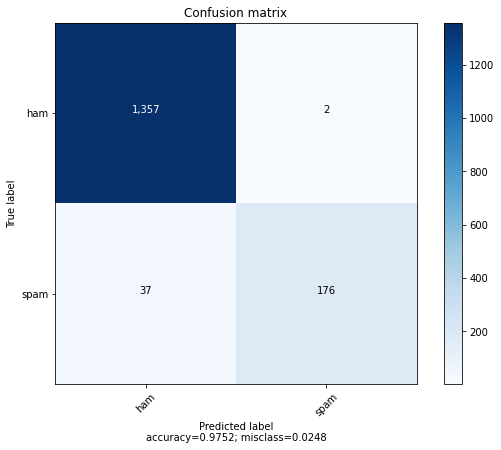

In [ ]:
createAndPlotCM(predictions, test_y)

In [ ]:
performanceDictionary = assesRecallPrecisionF1Score(test_y, predictions, "RF_tfidf", performanceDictionary)

F1_weighted: 0.9742381597154834
F1_micro: 0.9751908396946565
F1_macro: 0.9430446952545607

Recall_weighted: 0.9751908396946565
Recall_micro: 0.9751908396946565
Recall_macro: 0.9124097047331821

Precision_weighted: 0.975531630357297
Precision_micro: 0.9751908396946565
Precision_macro: 0.9811108603485241


## TF-IDF with PCA

In [ ]:
clf = RandomForestClassifier(max_depth=150, random_state=0)

In [ ]:
clf.fit(train_tfIdfPca, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=150, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
predictions = clf.predict(test_tfIdfPca)

In [ ]:
performanceDictionary = computeAccuracy(predictions, test_y, "RF_tfidfpca", performanceDictionary)

Accuracy: 0.9745547073791349


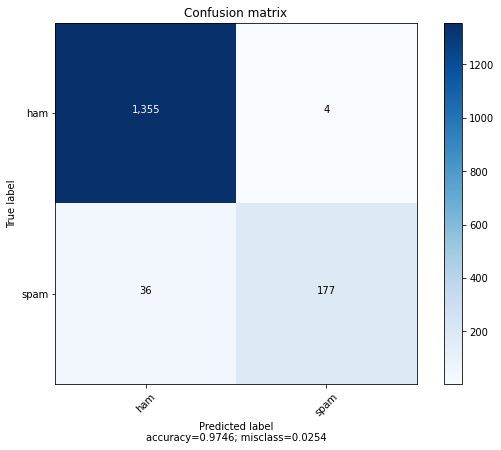

In [ ]:
createAndPlotCM(predictions, test_y)

In [ ]:
performanceDictionary = assesRecallPrecisionF1Score(test_y,predictions, "RF_tfidfpca", performanceDictionary)

F1_weighted: 0.9736694413425532
F1_micro: 0.9745547073791349
F1_macro: 0.9419658514074758

Recall_weighted: 0.9745547073791349
Recall_micro: 0.9745547073791349
Recall_macro: 0.9140212874006364

Precision_weighted: 0.9746316786540635
Precision_micro: 0.9745547073791349
Precision_macro: 0.9760099455457538


## Word Embeddings

In [ ]:
clf = RandomForestClassifier(max_depth=150, random_state=0)

In [ ]:
train_wordEmbeddingsRF = np.reshape(train_wordEmbeddings, [train_wordEmbeddings.shape[0],train_wordEmbeddings.shape[1]*train_wordEmbeddings.shape[2]])

In [ ]:
clf.fit(train_wordEmbeddingsRF, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=150, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
test_wordEmbeddingsRF = np.reshape(test_wordEmbeddings, [test_wordEmbeddings.shape[0],test_wordEmbeddings.shape[1]*test_wordEmbeddings.shape[2]])

In [ ]:
predictions = clf.predict(test_wordEmbeddingsRF)

In [ ]:
performanceDictionary = computeAccuracy(predictions, test_y, "RF_embeddings", performanceDictionary)

Accuracy: 0.9402035623409669


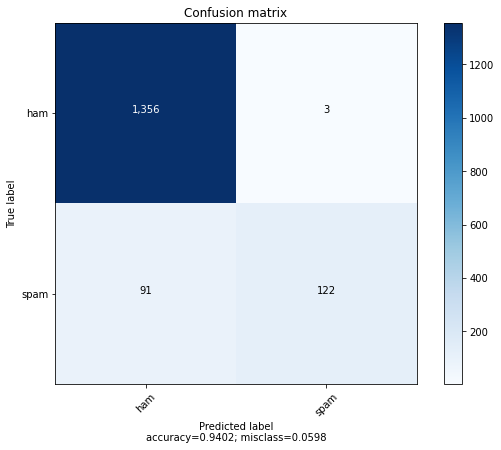

In [ ]:
createAndPlotCM(predictions, test_y)

In [ ]:
performanceDictionary = assesRecallPrecisionF1Score(test_y,predictions, "RF_embeddings", performanceDictionary)

F1_weighted: 0.9333570597511345
F1_micro: 0.9402035623409668
F1_macro: 0.844196923751724

Recall_weighted: 0.9402035623409669
Recall_micro: 0.9402035623409669
Recall_macro: 0.7852812237664397

Precision_weighted: 0.942380539890376
Precision_micro: 0.9402035623409669
Precision_macro: 0.9565556323427782


In [ ]:
performanceDictionary

{'RF_embeddings_accuracy': 0.9402035623409669,
 'RF_embeddings_f1_macro': 0.844196923751724,
 'RF_embeddings_f1_micro': 0.9402035623409668,
 'RF_embeddings_f1_weighted': 0.9333570597511345,
 'RF_embeddings_precision_macro': 0.9565556323427782,
 'RF_embeddings_precision_micro': 0.9402035623409669,
 'RF_embeddings_precision_weighted': 0.942380539890376,
 'RF_embeddings_recall_macro': 0.7852812237664397,
 'RF_embeddings_recall_micro': 0.9402035623409669,
 'RF_embeddings_recall_weighted': 0.9402035623409669,
 'RF_tfidf_accuracy': 0.9751908396946565,
 'RF_tfidf_f1_macro': 0.9430446952545607,
 'RF_tfidf_f1_micro': 0.9751908396946565,
 'RF_tfidf_f1_weighted': 0.9742381597154834,
 'RF_tfidf_precision_macro': 0.9811108603485241,
 'RF_tfidf_precision_micro': 0.9751908396946565,
 'RF_tfidf_precision_weighted': 0.975531630357297,
 'RF_tfidf_recall_macro': 0.9124097047331821,
 'RF_tfidf_recall_micro': 0.9751908396946565,
 'RF_tfidf_recall_weighted': 0.9751908396946565,
 'RF_tfidfpca_accuracy': 0.97

# Deep Learning Model

## TF-IDF

In [ ]:
def tfIdf(input_shape):

    X_input = Input(input_shape)

    X = Dense(500, activity_regularizer=l2(0.01), name = "dense_1")(X_input)
    X = LeakyReLU(alpha=0.1)(X)

    X = Dense(250, activity_regularizer=l2(0.01), name = "cnn_dense_2")(X)
    X = LeakyReLU(alpha=0.1)(X)

    X = Dense(50, activity_regularizer=l2(0.01), name = "cnn_dense_3")(X)
    X = Dropout(0.5, name='dropout_cnn')(X)

    X = Dense(2, name='fc')(X)

    model = Model(inputs = [X_input], outputs = X, name='TfIdf')

    return model

In [ ]:
tfIdfModel = tfIdf((train_tfIdfall.shape[1]))

In [ ]:
print(tfIdfModel.summary())

Model: "TfIdf"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 6665)]            0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               3333000   
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 500)               0         
_________________________________________________________________
cnn_dense_2 (Dense)          (None, 250)               125250    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 250)               0         
_________________________________________________________________
cnn_dense_3 (Dense)          (None, 50)                12550     
_________________________________________________________________
dropout_cnn (Dropout)        (None, 50)                0     

In [ ]:
adam = Adam(lr=1e-4)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
tfIdfModel.compile(optimizer = adam, loss = "CategoricalCrossentropy", metrics = ["categorical_crossentropy"])

In [ ]:
version = "tfIdfModel"

In [ ]:
mc = callbacks.ModelCheckpoint("/content/drive/My Drive/Side Projects/FinancialNewsSentiment/" + str(version) + '.h5', 
                                 save_weights_only=True, save_best_only=True,monitor='val_loss', mode='min', verbose = 1)
es = callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [ ]:
tfIdfModel.fit(x = train_tfIdfall  , y = train_y, epochs = 30, batch_size = 64, validation_split=0.1, callbacks=[mc, es])

Epoch 1/30
57/57 [==============================] - 3s 43ms/step - loss: 2.3162 - categorical_crossentropy: 2.3142 - val_loss: 0.5280 - val_categorical_crossentropy: 0.5260

Epoch 00001: val_loss improved from inf to 0.52797, saving model to /content/drive/My Drive/Side Projects/FinancialNewsSentiment/tfIdfModel.h5
Epoch 2/30
57/57 [==============================] - 2s 38ms/step - loss: 1.9354 - categorical_crossentropy: 1.9334 - val_loss: 4.1911 - val_categorical_crossentropy: 4.1891

Epoch 00002: val_loss did not improve from 0.52797
Epoch 3/30
57/57 [==============================] - 2s 37ms/step - loss: 3.1734 - categorical_crossentropy: 3.1714 - val_loss: 1.4845 - val_categorical_crossentropy: 1.4825

Epoch 00003: val_loss did not improve from 0.52797
Epoch 4/30
57/57 [==============================] - 2s 39ms/step - loss: 1.7279 - categorical_crossentropy: 1.7259 - val_loss: 1.4041 - val_categorical_crossentropy: 1.4021

Epoch 00004: val_loss did not improve from 0.52797
Epoch 00

In [ ]:
tfIdfModel.load_weights("/content/drive/My Drive/Side Projects/FinancialNewsSentiment/" + str(version) + '.h5')

In [ ]:
predictions = tfIdfModel.predict(test_tfIdfall)

In [ ]:
performanceDictionary = computeAccuracyNN(predictions, test_y, "NN_tfidf", performanceDictionary)

Accuracy: 0.8772264631043257


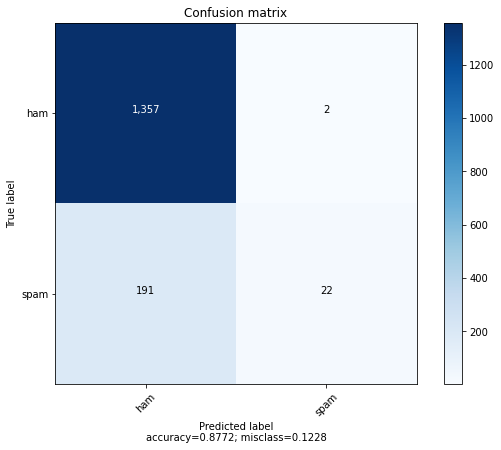

In [ ]:
createAndPlotCM(predictions, test_y)

In [ ]:
performanceDictionary = assesRecallPrecisionF1Score(test_y,predictions, "NN_tfidf", performanceDictionary)

F1_weighted: 0.832263548095113
F1_micro: 0.8772264631043256
F1_macro: 0.5596312697852848

Recall_weighted: 0.8772264631043257
Recall_micro: 0.8772264631043257
Recall_macro: 0.5509073573153417

Precision_weighted: 0.8820418367950766
Precision_micro: 0.8772264631043257
Precision_macro: 0.896640826873385


## TF-IDF with PCA

In [ ]:
def tfIdf(input_shape):

    X_input = Input(input_shape)

    X = Dense(500, activity_regularizer=l2(0.01), name = "dense_1")(X_input)
    X = LeakyReLU(alpha=0.1)(X)

    X = Dense(250, activity_regularizer=l2(0.01), name = "cnn_dense_2")(X)
    X = LeakyReLU(alpha=0.1)(X)

    X = Dense(50, activity_regularizer=l2(0.01), name = "cnn_dense_3")(X)
    X = Dropout(0.5, name='dropout_cnn')(X)

    X = Dense(2, name='fc')(X)

    model = Model(inputs = [X_input], outputs = X, name='TfIdf')

    return model

In [ ]:
tfIdfModel = tfIdf((train_tfIdfPca.shape[1]))

In [ ]:
print(tfIdfModel.summary())

Model: "TfIdf"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               25500     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 500)               0         
_________________________________________________________________
cnn_dense_2 (Dense)          (None, 250)               125250    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 250)               0         
_________________________________________________________________
cnn_dense_3 (Dense)          (None, 50)                12550     
_________________________________________________________________
dropout_cnn (Dropout)        (None, 50)                0     

In [ ]:
adam = Adam(lr=1e-4)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
tfIdfModel.compile(optimizer = adam, loss = "CategoricalCrossentropy", metrics = ["categorical_crossentropy"])

In [ ]:
version = "tfIdfPCAModel"

In [ ]:
mc = callbacks.ModelCheckpoint("/content/drive/My Drive/Side Projects/FinancialNewsSentiment/" + str(version) + '.h5', 
                                 save_weights_only=True, save_best_only=True,monitor='val_loss', mode='min', verbose = 1)
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [ ]:
tfIdfModel.fit(x = train_tfIdfPca  , y = train_y, epochs = 50, batch_size = 32, validation_split=0.1, callbacks=[mc, es])

Epoch 1/50
113/113 [==============================] - 2s 8ms/step - loss: 1.3336 - categorical_crossentropy: 1.3290 - val_loss: 0.2216 - val_categorical_crossentropy: 0.2167

Epoch 00001: val_loss improved from inf to 0.22157, saving model to /content/drive/My Drive/Side Projects/FinancialNewsSentiment/tfIdfPCAModel.h5
Epoch 2/50
113/113 [==============================] - 1s 5ms/step - loss: 1.1274 - categorical_crossentropy: 1.1228 - val_loss: 0.9677 - val_categorical_crossentropy: 0.9628

Epoch 00002: val_loss did not improve from 0.22157
Epoch 3/50
113/113 [==============================] - 1s 5ms/step - loss: 3.3450 - categorical_crossentropy: 3.3405 - val_loss: 1.2977 - val_categorical_crossentropy: 1.2927

Epoch 00003: val_loss did not improve from 0.22157
Epoch 4/50
113/113 [==============================] - 1s 5ms/step - loss: 4.4272 - categorical_crossentropy: 4.4225 - val_loss: 0.5120 - val_categorical_crossentropy: 0.5068

Epoch 00004: val_loss did not improve from 0.22157
E

In [ ]:
tfIdfModel.load_weights("/content/drive/My Drive/Side Projects/FinancialNewsSentiment/" + str(version) + '.h5')

In [ ]:
predictions = tfIdfModel.predict(test_tfIdfPca)

In [ ]:
performanceDictionary = computeAccuracyNN(predictions, test_y, "NN_tfidfpca", performanceDictionary)

Accuracy: 0.9484732824427481


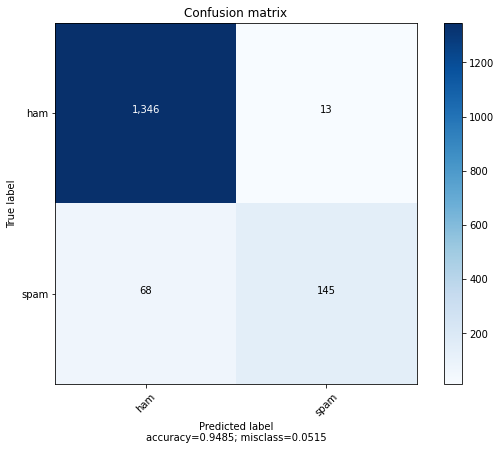

In [ ]:
createAndPlotCM(predictions, test_y)

In [ ]:
performanceDictionary = assesRecallPrecisionF1Score(test_y,predictions, "NN_tfidfpca", performanceDictionary)

F1_weighted: 0.945164909998565
F1_micro: 0.9484732824427481
F1_macro: 0.8762304587070355

Recall_weighted: 0.9484732824427481
Recall_micro: 0.9484732824427481
Recall_macro: 0.8355926582304719

Precision_weighted: 0.9472771388854304
Precision_micro: 0.9484732824427481
Precision_macro: 0.9348154978246468


## Word Embeddings

In [ ]:
def WordEmbeddingsMod(input_shape_LSTM, input_shape_CNN):

    fusion_layer_neurons = 50

    X_input_LSTM = Input(input_shape_LSTM)
    X_input_CNN = Input(input_shape_CNN)

    X_LSTM = LSTM(units = 600, return_sequences=True, name = 'lstm_1')(X_input_LSTM)

    X_CNN = Conv1D(32, kernel_size = 2, name = 'conv_1', input_shape = (21,1))(X_input_CNN)
    X_CNN = Conv1D(32, kernel_size = 4, name = 'conv_2')(X_CNN)

    X_LSTM = Flatten(name = "lstm_flatten_1")(X_LSTM)
    X_LSTM = LeakyReLU(alpha=0.2)(X_LSTM)
    X_LSTM = Dense(fusion_layer_neurons, activity_regularizer=l2(0.01), name = "lstm_dense_2")(X_LSTM)
    X_LSTM = Dropout(0.5, name='dropout_lstm')(X_LSTM)

    X_CNN = Flatten(name = "cnn_flatten_1")(X_CNN)
    X_CNN = LeakyReLU(alpha=0.2)(X_CNN)
    X_CNN = Dense(fusion_layer_neurons, activity_regularizer=l2(0.01), name = "cnn_dense_2")(X_CNN)
    X_CNN = Dropout(0.5, name='dropout_cnn')(X_CNN)

    X = Add(name = "fusion")([X_LSTM, X_CNN])

    X = Dense(2, name='fc')(X)

    model = Model(inputs = [X_input_LSTM, X_input_CNN], outputs = X, name='WordEmbeddings')

    return model

In [ ]:
WordEmbeddingsModel = WordEmbeddingsMod((train_wordEmbeddings.shape[1],train_wordEmbeddings.shape[2]),(train_wordEmbeddings.shape[1],train_wordEmbeddings.shape[2]))

In [ ]:
print(WordEmbeddingsModel.summary())

Model: "WordEmbeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 15, 300)]    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 15, 300)]    0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 14, 32)       19232       input_4[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 15, 600)      2162400     input_3[0][0]                    
_____________________________________________________________________________________

In [ ]:
adam = Adam(lr=1e-4)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
WordEmbeddingsModel.compile(optimizer = adam, loss = "CategoricalCrossentropy", metrics = ["categorical_crossentropy"])

In [ ]:
version = "WordEmbeddingsModel"

In [ ]:
mc = callbacks.ModelCheckpoint("/content/drive/My Drive/Side Projects/FinancialNewsSentiment/" + str(version) + '.h5', 
                                 save_weights_only=True, save_best_only=True,monitor='val_loss', mode='min', verbose = 1)
es = callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [ ]:
WordEmbeddingsModel.fit(x = [train_wordEmbeddings,train_wordEmbeddings]  , y = train_y, epochs = 50, batch_size = 64, validation_split=0.1, callbacks=[mc, es])

Epoch 1/50
57/57 [==============================] - 23s 356ms/step - loss: 3.1339 - categorical_crossentropy: 3.1227 - val_loss: 2.9308 - val_categorical_crossentropy: 2.9198

Epoch 00001: val_loss improved from inf to 2.93078, saving model to /content/drive/My Drive/Side Projects/FinancialNewsSentiment/WordEmbeddingsModel.h5
Epoch 2/50
57/57 [==============================] - 20s 343ms/step - loss: 3.2919 - categorical_crossentropy: 3.2805 - val_loss: 2.9283 - val_categorical_crossentropy: 2.9173

Epoch 00002: val_loss improved from 2.93078 to 2.92827, saving model to /content/drive/My Drive/Side Projects/FinancialNewsSentiment/WordEmbeddingsModel.h5
Epoch 3/50
57/57 [==============================] - 21s 360ms/step - loss: 2.9840 - categorical_crossentropy: 2.9721 - val_loss: 1.7608 - val_categorical_crossentropy: 1.7490

Epoch 00003: val_loss improved from 2.92827 to 1.76085, saving model to /content/drive/My Drive/Side Projects/FinancialNewsSentiment/WordEmbeddingsModel.h5
Epoch 4/

In [ ]:
WordEmbeddingsModel.load_weights("/content/drive/My Drive/Side Projects/FinancialNewsSentiment/" + str(version) + '.h5')

In [ ]:
predictions = WordEmbeddingsModel.predict([test_wordEmbeddings,test_wordEmbeddings])

In [ ]:
performanceDictionary = computeAccuracyNN(predictions, test_y, "NN_embeddings", performanceDictionary)

Accuracy: 0.8772264631043257


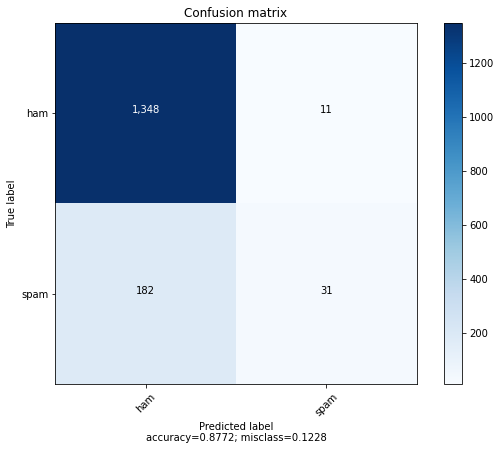

In [ ]:
createAndPlotCM(predictions, test_y)

In [ ]:
performanceDictionary = assesRecallPrecisionF1Score(test_y,predictions, "NN_embeddings", performanceDictionary)

F1_weighted: 0.8396947031172699
F1_micro: 0.8772264631043256
F1_macro: 0.5881660660110358

Recall_weighted: 0.8772264631043257
Recall_micro: 0.8772264631043257
Recall_macro: 0.5687228596005762

Precision_weighted: 0.8616765026621336
Precision_micro: 0.8772264631043257
Precision_macro: 0.8095704948646125


# Comparison of models' performance, conclusion and further research

In [ ]:
performance_names = ["NN_tfidf_f1_macro", 
                     "NN_tfidfpca_f1_macro", 
                     "NN_embeddings_f1_macro", 
                     "RF_tfidf_f1_macro", 
                     "RF_tfidfpca_f1_macro",
                     "RF_embeddings_f1_macro"]

performance_values = [performanceDictionary["NN_tfidf_f1_macro"],
                      performanceDictionary["NN_tfidfpca_f1_macro"],
                      performanceDictionary["NN_embeddings_f1_macro"],
                      performanceDictionary["RF_tfidf_f1_macro"],
                      performanceDictionary["RF_tfidfpca_f1_macro"],
                      performanceDictionary["RF_embeddings_f1_macro"]]

<BarContainer object of 6 artists>

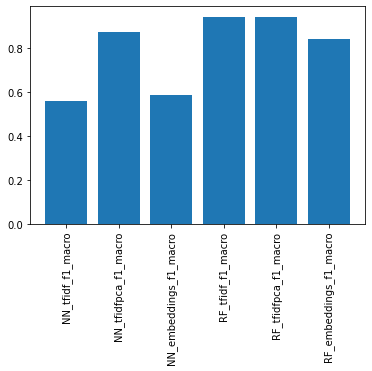

In [ ]:
plt.xticks(rotation='vertical')
plt.bar(performance_names,performance_values)

As you could see from the bar plot above, the best performing model is RF model with TF-IDF features (performs slightly better than TF-IDF with PCA). It is also interesting that all RF models perform better than NN models. 

## Next steps
* Investigate why RFC performs better than NN. 
* Experiment with different NN architectures.
* Try more more different preprocessing and feature engineering techniques.